# General processing of files

Files are stored in directories per season in the data directory. Unzip the All_Data.zip first. Each competition has its own abbreviation. Check below for these abreviations. For the explanation of the features, please read the notex.txt in the background_info directory

## Abreviations for competitions files:
- Belgium
    - B1 : Jupiler League
- Germany
    - D1 : Bundesliga 1
    - D2 : Bundesliga 2
- England
    - E0: Premier League
    - E1: Championship
    - E2: League 1
    - E3: League 2
    - EC: Conference
- France
    - F1: Le Championnat
    - F2: Division 2
- Greece
    -G1: Ethniki Katigoria
- Italy
    - I1: Serie A
    - I2: Serie B
- Netherlands
    - N1: Eredivisie
- Portugal
    - P1: Liga I
- Scotland
    - SC0: Premier League
    - SC1: Divison 1
    - SC2: Divison 2
    - SC3: Divison 3
- Spain
    - SP1: La Liga Primera Division
    - SP1: La Liga Segunda Division
- Turkey
    - T1: Futbol Ligi 1
    

## Main Feature Dimensions
The features can be subdivided into 6 categories. Below is the column list for each of the categories. Some but certainly not all competitions hold all data. Data on odds is exclusively from odds before the match, live betting odds are not included in the data.
1. Results Data
2. Match Statistics
3. Key to 1X2 (match) betting odds data
    - Last letter indicates team or draw: H(ome), A(way), D(draw)
4. Key to total goals betting odds
5. Key to Asian handicap betting odds
    - Last letter indicates team: H(ome), A(way)
6. Closing odds (last odds before match starts)
    - Last letter indicates team or draw: H(ome), A(way), D(draw)

In [3]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta
%matplotlib inline

In [4]:
# Features Names in Array's
results_data = ['Date','HomeTeam','AwayTeam','FTHG','FTAG','FTR'\
                ,'HTHG','HTAG','HTR']
match_stats = ['Attendance','Referee','HS','AS','HST','AST','HHW'\
               ,'AHW','HC','AC','HF','AF','HO','AO','HY','AY','HR'\
               ,'AR','HBP','ABP']
match_odds = ['B365H ','B365D ','B365A ','BSH ','BSD ','BSA ','BWH ','BWD '\
    ,'BWA ','GBH ','GBD ','GBA ','IWH ','IWD ','IWA ','LBH ','LBD '\
    ,'LBA ','PSH ','PSD ','PSA ','SOH ','SOD ','SOA ','SBH ','SBD '\
    ,'SBA ','SJH ','SJD ','SJA ','SYH ','SYD ','SYA ','VCH ','VCD '\
    ,'VCA ','WHH ','WHD ','WHA ','Bb1X2 ','BbMxH ','BbAvH ','BbMxD '\
    ,'BbAvD ','BbMxA ','BbAvA ']
goal_odds = ['BbOU ','BbMx>2.5 ','BbAv>2.5 ','BbMx<2.5 ','BbAv<2.5'\
             ,'GB>2.5','GB<2.5 ','B365>2.5 ','B365<2.5 ']
asian_odds = ['BbAH ','BbAHh ','BbMxAHH ','BbAvAHH ','BbMxAHA '\
              ,'BbAvAHA','GBAHH','GBAHA ','GBAH ','LBAHH ','LBAHA '\
              ,'LBAH ','B365AHH ','B365AHA ','B365AH']
closing_odds = ['PSCH ','PSCD ','PSCA ']

all_cols = ['season']
for i in [results_data,match_stats,match_odds,goal_odds,asian_odds,closing_odds]:
    all_cols = np.append(all_cols,i)

In [6]:
# All Available Seasons Check on you directory
available_seasons = [x[0] for x in os.walk('../Data')]
for i in available_seasons:
    print i[8:17]


1995_1996
1996_1997
1997_1998
1998_1999
1999_2000
2000_2001
2001_2002
2002_2003
2003_2004
2004_2005
2005_2006
2006_2007
2007_2008
2008_2009
2009_2010
2010_2011
2011_2012
2012_2013
2013_2014
2014_2015
2015_2016
2016_2017


The function below can read data in per competition and season. Specify the columns you want or use the predefined arrays, as indicated above. The function assumes dir structure as imposed in this repo. Loading in all data is also possible, use * to indicate this

In [43]:
def read_data(competition,columns_to_include,season='*',read_in_type='Loose'):
    #string to filepath
    comp_season_str = '../Data/'+ str(season)+'/'+str(competition)+'.csv'
    #glob functions takes all files in a path and stores them in a list
    allFiles = glob.glob(comp_season_str)
    #Sometimes some a file will be entered multiple time in the list
    #To ensure it is readin only once, the list is made unique
    allFiles = np.unique(np.array(allFiles))
    #Initialize empty frame and list
    frame = pd.DataFrame()
    list_ = []
    for file_ in allFiles:
        #Feedback from th function which files are feeded into the resulting frame
        print 'Data added from:', file_
        #Some rows in the files contain trailing commas without any info
        #Pandas does not like this and will error out
        # This function allows the user to choose 2 options to prevent this
        # 1. Loose: Use the header column of the file to determine the ammount of
        #           columns to be read. For all lines only read in this ammount.
        #           All lines will be read
        # 2. Robust: Only read in files that have an consisten layout throught
        #            the file, i.e. every line has the same ammount of cols as
        #            the header line. This will cause some line to be skipped
        #Loose will be used by default
        if read_in_type == 'Loose':
            cols = pd.read_csv(file_, nrows=1).columns
            df = pd.read_csv(file_, usecols=cols,index_col=None, header=0, parse_dates=['Date'])
        elif read_in_type == 'Robust':
            df = pd.read_csv(file_,index_col=None, header=0, error_bad_lines=False,parse_dates=['Date'])
        #The files do not contain any reference to the season they are from
        #therefore this is added for each file that is added to the list
        #by using the path it is taken from
        ind = file_.index('_')
        df['season'] = file_[(ind-4):(ind+5)]
        list_.append(df)
    #Last step is to concatenate all files (allready in dataframe form)
    frame = pd.concat(list_,ignore_index=True)
    #Finally only the collumns specified will be kept in the overall dataframe
    frame = frame[np.append(frame.columns.values[np.in1d(frame.columns.values,columns_to_include)],'season')]
    return frame

### Example All Eredivisie Data

In [44]:
data = read_data('N1',np.append(results_data,match_stats))

Data added from: ../Data\1995_1996\N1.csv
Data added from: ../Data\1996_1997\N1.csv
Data added from: ../Data\1997_1998\N1.csv
Data added from: ../Data\1998_1999\N1.csv
Data added from: ../Data\1999_2000\N1.csv
Data added from: ../Data\2000_2001\N1.csv
Data added from: ../Data\2001_2002\N1.csv
Data added from: ../Data\2002_2003\N1.csv
Data added from: ../Data\2003_2004\N1.csv
Data added from: ../Data\2004_2005\N1.csv
Data added from: ../Data\2005_2006\N1.csv
Data added from: ../Data\2006_2007\N1.csv
Data added from: ../Data\2007_2008\N1.csv
Data added from: ../Data\2008_2009\N1.csv
Data added from: ../Data\2009_2010\N1.csv
Data added from: ../Data\2010_2011\N1.csv
Data added from: ../Data\2011_2012\N1.csv
Data added from: ../Data\2012_2013\N1.csv
Data added from: ../Data\2013_2014\N1.csv
Data added from: ../Data\2014_2015\N1.csv
Data added from: ../Data\2015_2016\N1.csv
Data added from: ../Data\2016_2017\N1.csv


### Some plots of the data just collected

In [46]:
data.columns.values

array(['AwayTeam', 'Date', 'FTAG', 'FTHG', 'FTR', 'HTAG', 'HTHG', 'HTR',
       'HomeTeam', 'season'], dtype=object)

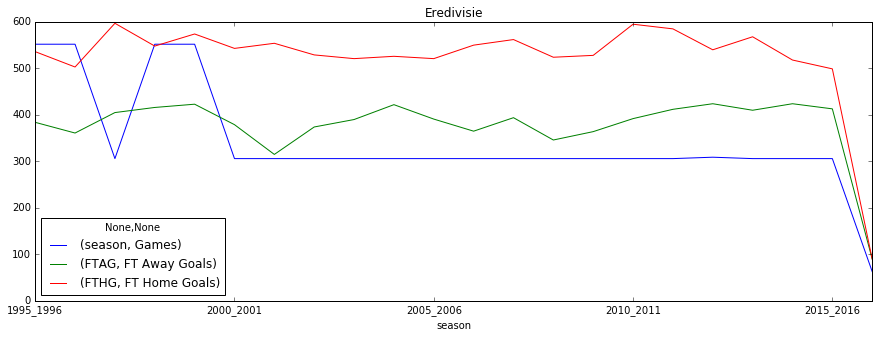

In [64]:
data.groupby(['season']).agg({'season':{'Games':'count'}
                             ,'FTHG':{'FT Home Goals':'sum'}
                             ,'FTAG':{'FT Away Goals':'sum'}
                             }).plot(figsize=(15,5))
plt.title('Eredivisie')

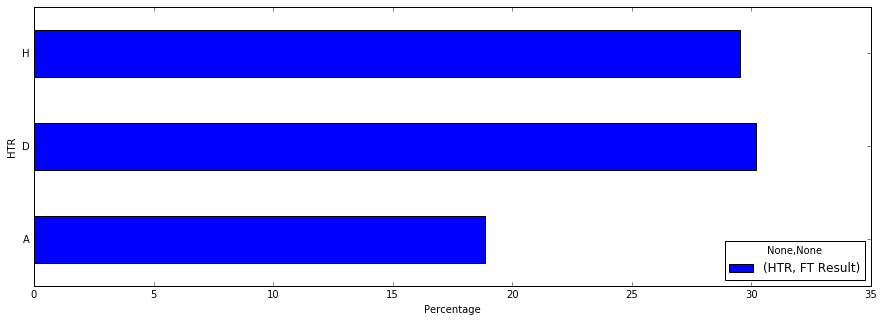

In [66]:
(100*data.groupby('HTR')['HTR'].agg({'HTR':{'FT Result':'count'}})/len(data)).plot(kind='barh',figsize=(15,5))
plt.xlabel('Percentage')

In [62]:
data.HomeTeam.value_counts().head(5)

Twente        361
Utrecht       360
Ajax          360
Heerenveen    360
Feyenoord     360
Name: HomeTeam, dtype: int64